# Practical session 4 - K-nearest neighbours (K-NN) classification with numpy, scikit-learn, cython and numba

Students (pair):
- [Student 1]([link](https://github.com/username1))
- [Student 2]([link](https://github.com/username2))

**Useful references for this lab**:

[1] scikit-learn: [documentation](https://scikit-learn.org/stable/modules/neighbors.html?highlight=knn%20classification)

[2] `numba`: [documentation](http://numba.pydata.org/) 

[3] cython: [a very useful tutorial](https://cython.readthedocs.io/en/latest/src/userguide/numpy_tutorial.html#numpy-tutorial), and [another one](http://docs.cython.org/en/latest/src/tutorial/cython_tutorial.html)



## <a name="content">Contents</a>
- [Exercise 1: KNN classification with numpy and sklearn](#ex1)
- [Exercise 2: Code acceleration with cython](#ex2)
- [Exercise 3: Code acceleration with numba](#ex3)
---

In [1]:
import pdb
%load_ext autoreload
%autoreload 2

## <a name="ex1">Exercise 1: K-Nearest Neighbours (K-NN) classification with numpy and scikit-learn</a> [(&#8593;)](#content)

This session is a first introduction to classification using the most intuitive non parametric method: the $K$-nearest neighbours. The principle is [the following](https://scikit-learn.org/stable/modules/neighbors.html?highlight=knn%20classification). A set of labelled observations is given as a learning set. A classification taks then consists in assigning a label to any new observation. In particular, the K-NN approach consists in assigning to the observation the most frequent label among its $K$ nearest neighbours taken in the training set.

### A. Validation on synthetic data

Load the training and test datasets `data/synth_train.txt` and `data/synth_test.txt`. Targets belong to the set $\{1,2\}$ and entries belong to $\mathbb{R}^2$. The file `data/synth_train.txt` contain 100 training data samples, and `data/synth_test.txt` contains 200 test samples, where:

- the 1st column contains the label of the class the sample;
- columns 2 & 3 contain the coordinates of each sample (in $\mathbb{R}^2$).

Useful commands can be found below.

In [2]:
# load the training set
import numpy as np
train = np.loadtxt('data/synth_train.txt')  #...,delimiter=',') if there are ',' as delimiters
class_train = train[:,0]
x_train = train[:,1:]
N_train = train.shape[0]

In [3]:
# load the test set
test = np.loadtxt('data/synth_test.txt') 
class_test_1 = test[test[:,0]==1]
class_test_2 = test[test[:,0]==2]
class_test=test[:,0]
x_test = test[:,1:]
N_test = test.shape[0]


1\. Display the training set and distinguish the two classes. 

> Hint: useful functions include `matplotlib.pyplot.scatter` or `matplotlib.pyplot.plot`.

**Answer:**

Text(0.5, 1.0, 'Points entrainement du data set ')

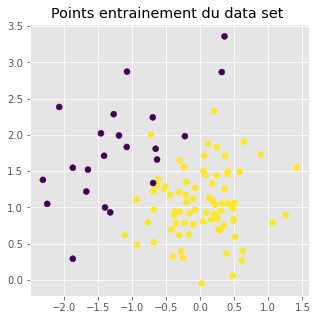

In [4]:
# your code
import matplotlib.pyplot as plt
plt.style.use("ggplot")
plt.figure(figsize=(5,5))
plt.scatter(x_train[:,0],x_train[:,1],c=class_train)
plt.title('Points entrainement du data set ')

2\. Implement the K-nearest neighbours algorithm for classification.

> Hint: 
> - useful functions include `numpy.linalg.norm`, `numpy.argsort`, `numpy.bincount`;
> - implement the algorithm as a function rather than an object. This will drastically simplify the acceleration step using Cython.
> - for an optimized partial sorting procedure, you may have a look at the [`bottleneck.argpartition` function](https://bottleneck.readthedocs.io/en/latest/reference.html#bottleneck.argpartition).

**Answer:**

In [5]:
dtype = [('distance', float), ('target', float)]

def classifier_Knn_numpy(x_train,x_new,targets,K):
    distances = []
    counter1 = 0
    counter2 = 0
    for i in range(0,len(x_train)):
        distances.append((np.linalg.norm(x_new-x_train[i]),targets[i]))
    distances=np.array(distances,dtype=dtype)
    distances=np.sort(distances,order='distance')  # plus petites en premier
    for j in range(0,K):
        if distances[j][1]==1.:
            counter1+=1
        if distances[j][1]==2.:
            counter2+=1
        if counter1+counter2==K:
            break
    if counter1>counter2:
        return 1.
    else:
        return 2.


3\. Compute the error rate on the training set and the test set for $K \in \{1,2, \dotsc, 20\}$. Display the classification result (see 1.) for the configuration with the lowest error rate.

In [6]:
def testWithTrainOnTest(x_train,X_new,class_train,K):
    target_prediction_test = []
    for x in X_new:
        target_prediction_test.append(classifier_Knn_numpy(x_train,x_new=x,targets=class_train,K=K))
    return target_prediction_test


#Compute error rate
def computeError(target_prediction_test,class_test):
    return sum(abs(target_prediction_test-class_test))/len(class_test)


([<matplotlib.axis.XTick at 0x1d8f6c5be80>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

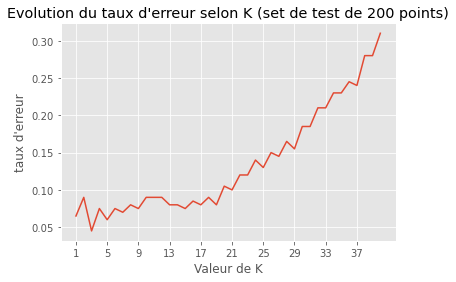

In [7]:
tabError=[]
nbTest=40
for k in range(1,nbTest+1):
    tabError.append(computeError(testWithTrainOnTest(x_train,x_test,class_train,k),class_test))
plt.figure()
plt.plot(np.linspace(1,nbTest,nbTest),tabError)
plt.title("Evolution du taux d'erreur selon K (set de test de 200 points)")
plt.xlabel("Valeur de K")
plt.ylabel("taux d'erreur")
plt.xticks(np.arange(1, nbTest+1,4,dtype=int))

Un $K_{optimal}$ semble être 3 puisqu'il commet le moins d'erreur.

Taux d'erreur pour K=3 : 0.045


Text(0.5, 1.0, 'Vraies valeur de la classe test')

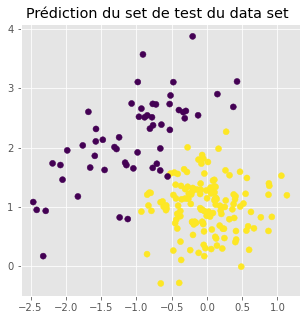

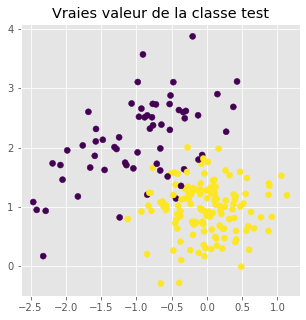

In [8]:
target_prediction_test=testWithTrainOnTest(x_train,x_test,class_train,K=3)  #Prédit les valeurs de x_test sachant class_train
error=computeError(target_prediction_test,class_test)
print("Taux d'erreur pour K=3 : "+str(error))
plt.style.use("ggplot")
plt.figure(figsize=(5,5))
#plt.scatter(x_train[:,0],x_train[:,1],c=class_train)
plt.scatter(x_test[:,0],x_test[:,1],c=target_prediction_test)
plt.title('Prédiction du set de test du data set ')
plt.figure(figsize=(5,5))
plt.scatter(x_test[:,0],x_test[:,1],c=class_test)
plt.title('Vraies valeur de la classe test')

4\. Comment on your results. Which value of $K$ seems optimal ?


**Answer:**
le choix d'un K=3 convient bien pour ce problème. En effet les points d'entrainement et de test sont quasiment linéairement séparables.
Cela nous conforte dans l'idee que le classifieur KNN n'a pas besoin de vérifier beaucoup de voisins pour choisir.
En poussant ce raisonnement à la limite : 1 seul voisin devrait suffire dans le cas linéairement séparable car le voisin le plus proche nous indique de "quel coté" l'on se trouve.
Pour ce problème, la présence de quelques points en dehors de leur zone de haute probabilité (point de la classe 1 dans une zone avec majoritairement des points de classe 2) donne un K optimal de 3 voisins à vérifier.

Taux d'erreur pour K=3 : 0.045


De plus, on remarque que si K tends vers l'infini, l'erreur augmente de même. C'est normal puisque pour K = taille des données de fit le classifieur va toujours classer un point dans la classe la plus probable.

5\. Compare the results of you implementation with those of [`sklearn.neighbors.KNeighborsClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html?highlight=kneighborsclassifier#sklearn.neighbors.KNeighborsClassifier). Compare the runtime of these two versions using the [`timeit`](https://docs.python.org/3/library/timeit.html) module (see session 1).

**Answer:**

Taux d'erreur pour K=3 : 0.045


Text(0.5, 1.0, 'Vraies valeur de la classe test')

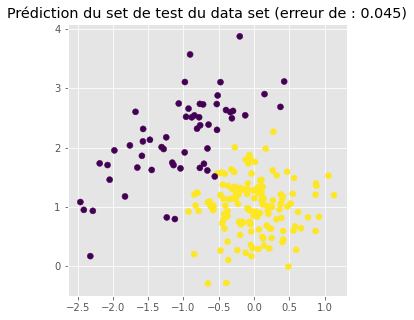

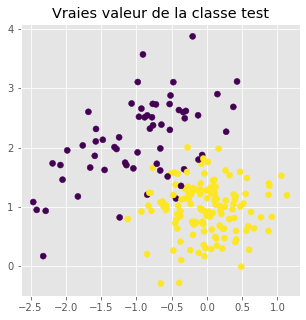

In [9]:
# your code
from sklearn.neighbors import KNeighborsClassifier

classifierKnn_sklearn=KNeighborsClassifier(n_neighbors=3).fit(x_train,class_train)
target_prediction_test_sklearn = classifierKnn_sklearn.predict(x_test)
error = computeError(target_prediction_test_sklearn,class_test)
print("Taux d'erreur pour K=3 : "+str(error))
plt.style.use("ggplot")
plt.figure(figsize=(5,5))
#plt.scatter(x_train[:,0],x_train[:,1],c=class_train)
plt.scatter(x_test[:,0],x_test[:,1],c=target_prediction_test_sklearn)
plt.title('Prédiction du set de test du data set (erreur de : '+str(error)+')')
plt.figure(figsize=(5,5))
plt.scatter(x_test[:,0],x_test[:,1],c=class_test)
plt.title('Vraies valeur de la classe test')


**Taux d'erreur**
Taux d'erreur pour K=3 : 0.045

On remarque que le taux d'erreur est le même que celui de notre classifieurKNN "maison".
Vérifions la différence de taux d'erreur pour différents cas :


([<matplotlib.axis.XTick at 0x19fde7d5a48>,
 <a list of 10 Text xticklabel objects>)

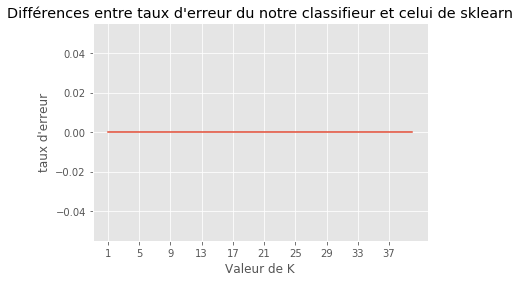

In [11]:
tabError=[]
nbTest=40
for k in range(1,nbTest+1):
    classifierKnn_sklearn=KNeighborsClassifier(n_neighbors=k).fit(x_train,class_train)
    errSKL=computeError(classifierKnn_sklearn.predict(x_test),class_test)
    errKNN=computeError(testWithTrainOnTest(x_train,x_test,class_train,k),class_test)
    tabError.append(abs(errKNN-errKNN))
plt.figure()
plt.plot(np.linspace(1,nbTest,nbTest),tabError)
plt.title("Différences entre taux d'erreur du notre classifieur et celui de sklearn")
plt.xlabel("Valeur de K")
plt.ylabel("taux d'erreur")
plt.xticks(np.arange(1, nbTest+1,4,dtype=int))

On remarque que l'erreur de notre classifieur est toujours la même que le classifieur de sklearn.
Vérifions en revanche le temps d'exécution de ces programmes : 

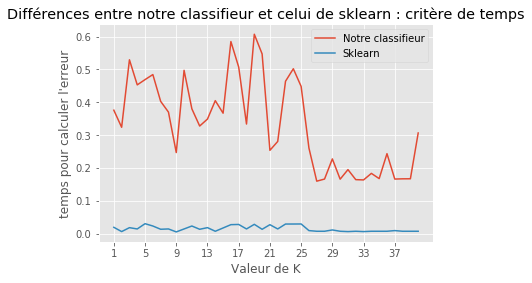

In [12]:
from time import time

timeSklearn = []
timePerso = []
nbTest=40
for k in range(1,nbTest+1):
    classifierKnn_sklearn=KNeighborsClassifier(n_neighbors=k).fit(x_train,class_train)
    startSklearn=time()
    errSKL=computeError(classifierKnn_sklearn.predict(x_test),class_test)
    timeSklearn.append(time()-startSklearn)
    startPerso=time()
    errKNN=computeError(testWithTrainOnTest(x_train,x_test,class_train,k),class_test)
    timePerso.append(time()-startPerso)
plt.figure()
plt.plot(np.linspace(1,nbTest,nbTest),timePerso,label='Notre classifieur')
plt.plot(np.linspace(1,nbTest,nbTest),timeSklearn,label='Sklearn')
plt.legend()
plt.title("Différences entre notre classifieur et celui de sklearn : critère de temps")
plt.xlabel("Valeur de K")
plt.ylabel("temps pour calculer l'erreur")
plt.xticks(np.arange(1, nbTest+1,4,dtype=int))
plt.show()

Il est clair que notre classifieur prend plus de temps pour calculer l'erreur.
De plus le temps de calcul de sklearn augmente beaucoup moins vite que le notre.
Il faudrait tester la différence pour un très gros dataset pour bien voir les tendances.

### B. Application to a real dataset (Breast cancer Wisconsin).

6\. Apply the K-NN classifier to the real dataset `data/wdbc12.data.txt.` Further details about the data are provided in `data/wdbc12.names.txt`.

> Hint: you can use the function [`train_test_split` from `sklearn.model_selection`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) to split the dataset into a training and a test set.

**Answer:**

In [11]:
# your code
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
df = np.loadtxt('data/wdbc12.data.txt',delimiter=',')
y = df[:,1]
x = df[:,2:]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)

target_prediction_test=testWithTrainOnTest(x_train,x_test,y_train,K=3)
error=computeError(target_prediction_test,y_test)
print("L'erreur commise est de : "+str(error))

L'erreur commise est de : 0.05851063829787234


L'erreur commise est de 0.05 soit une faible part de points mal prédits.
Voici la matrice de confusion pour voir le nombre de points mal prédits dans chaque classe (faux-négatif et faux-positif)

In [13]:
cM=confusion_matrix(target_prediction_test, y_test)
print(cM)

[[ 62   6]
 [  5 115]]


## <a name="ex2">Exercise 2: Code acceleration with cython</a> [(&#8593;)](#content)

Cython allows C code to be easily interfaced with Python. It can be useful to make your code faster for a small coding effort, in particular when using loops. A general approach to optimize your code is outlined in the [Scipy lecture notes, Section 2.4](https://scipy-lectures.org/advanced/optimizing/index.html). Complementary reading about interfacing Python with C can be found in [Section 2.8](https://scipy-lectures.org/advanced/interfacing_with_c/interfacing_with_c.html).

1\. Read carefully the [cython tutorial](http://docs.cython.org/en/latest/src/tutorial/cython_tutorial.html), which describes step by the step how the toy example reported below has been developed.

**Setup**: Compile the toy example provided in `example_cy/` by running, in the command line (anaconda prompt on windows)

```bash
cd example_cy && python setup.py build_ext --inplace
```

Note that the compilation process has been slightly automatised with the instructions reported in `example_cy/setup.py`. To test the module, run

In [14]:
!cd example_cy && python setup.py build_ext --inplace

Compiling helloworld.pyx because it changed.
Compiling primes.pyx because it changed.
[1/2] Cythonizing helloworld.pyx
[2/2] Cythonizing primes.pyx
running build_ext
building 'example_cy.helloworld' extension
creating build\temp.win-amd64-cpython-39
creating build\temp.win-amd64-cpython-39\Release
gcc -mdll -O -Wall -DMS_WIN64=1 -Ic:\Apps\Anaconda3\include -Ic:\Apps\Anaconda3\Include -c helloworld.c -o build\temp.win-amd64-cpython-39\Release\helloworld.o
writing build\temp.win-amd64-cpython-39\Release\helloworld.cp39-win_amd64.def
creating build\lib.win-amd64-cpython-39
creating build\lib.win-amd64-cpython-39\example_cy
gcc -shared -s build\temp.win-amd64-cpython-39\Release\helloworld.o build\temp.win-amd64-cpython-39\Release\helloworld.cp39-win_amd64.def -Lc:\Apps\Anaconda3\libs -Lc:\Apps\Anaconda3 -Lc:\Apps\Anaconda3\PCbuild\amd64 -lpython39 -lucrt -lvcruntime140 -o build\lib.win-amd64-cpython-39\example_cy\helloworld.cp39-win_amd64.pyd
building 'example_cy.primes' extension
gcc -mdl

In [15]:
import example_cy.example_cy.helloworld as toy

toy.printhello()

Hello World


which should display
```python
Hello World
```

> Warning: 
> - do not forget to include an empty `__init__.py` file in the directory where your source code lives (`import` will fail if this is not the case).
> - in case you have any setup issue, take a look at the `notes.md` file.
> - if the C code and/or the executable do not seem to be regenerated by the build instructions, delete the C code and the executable first, and re-execute the compilation afterwards.
> - do not hesitate to restart the Python kernel if necessary when the Cython executable has been re-generated.

2\. Read the [Numpy/Cython tutorial](https://cython.readthedocs.io/en/latest/src/userguide/numpy_tutorial.html#numpy-tutorial), focussing on the paragraphs **Cython at a glance**, and **Your Cython environment** until **"More generic code"**. An example to compile a `.pyx` file depending on `numpy` is included in `example_np_cy/`.

> Remarks: 
> - the `annotate=True` flag in the `setup.py` allows an additional `.html` document to be generated (`<your_module_name>.html`), showing, for each line of the Cython code, the associated C instructions generated. Highlighted in yellow are the interactions with Python: the darker a region appears, the less efficient the generated C code is for this section. Work in priority on these! 
> - make sure all the previously generated files are deleted to allow the .html report to be generated;
> - if you are working on your own machine and don't have a C/C++ compiler installed, read the notes provided in `notes.md`;
> - use `cdef` for pure C functions (not exported to Python), `cpdef` should be favored for functions containing C instructions and later called from Python.

**Answer:**

3\. Use Cython to implement a faster version of the numpy K-NN classifier implemented in [Exercise 1](#ex1). To do so, apply step-by-step the techniques introduced in the [Numpy/Cython tutorial](https://cython.readthedocs.io/en/latest/src/userguide/numpy_tutorial.html#numpy-tutorial) (*i.e.*, compile and time your code after each step to report the evolution, keeping track of the different versions of the cython function).

> Hint: if you keep numpy arrays, make sure you use memory views (see numpy/cython tutorial) to access the elements within it. Be extremely careful with the type of the input arrays (you may need to recast the format of the input elements before entering the function. The `numpy.asarray` function can prove useful).

> **Detailed guidelines**: a few notes and *caveat* to help you re-writing your code in cython:
> - try to reduce the number of calls to numpy instructions as much as possible;
> - **you do not have to optimize everything**. For the KNN function above, most of the time is spent in computing euclidean distances: you can thus focus on optimizing tihs operations by explicitly writing a for loop, which will ensure a minimal interaction with numpy when generating the associated C code at compilation. Calls to other numpy functions can be kept as-is;
> - if you need to create an array within the cython function, used np.zeros (**do NOT use python lists**), and use a memory view to access its content;
> - specify the type for all variables and numpy arrays. Pay attention to the type of the input arrays passed to the Cython function;
> - whenever an array is returned, use memory views and index(es) to efficiently access its content;
> - some numpy operators (e.g., broadcasting mechanism) do not work with memory views. In this case, you can directly write for loop(s) to encode the operation of interest (the loops will be optimized out at compile time);
> - only use at the final development stage the following cython optimization (not before, as they can crash the program without any help):
>
>```python
>@cython.boundscheck(False)
>@cython.wraparound(False)
>```

In [1]:
!cd KNN_Cython && python setup.py build_ext --inplace

Compiling KNN.pyx because it changed.
[1/1] Cythonizing KNN.pyx
running build_ext
building 'KNN' extension


error: Microsoft Visual C++ 14.0 or greater is required. Get it with "Microsoft C++ Build Tools": https://visualstudio.microsoft.com/visual-cpp-build-tools/


**Answer:**

In [17]:
# load the test set
test = np.loadtxt('data/synth_test.txt')
class_test_1 = test[test[:,0]==1]
class_test_2 = test[test[:,0]==2]
class_test=test[:,0]
x_test = test[:,1:]
N_test = test.shape[0]

# load the training set
import numpy as np
train = np.loadtxt('data/synth_train.txt')  #...,delimiter=',') if there are ',' as delimiters
class_train = train[:,0]
x_train = train[:,1:]
N_train = train.shape[0]

4\. Compare the runtime of the two algorithms (using `timeit.timeit`), and conclude about the interest of using cython in this case.

**Answer:**

In [3]:
import KNN_Cython.KNN as KNN
from sklearn.neighbors import KNeighborsClassifier
import timeit

from time import time

timeSklearn = []
timePerso = []
timePerso2 = []
nbTest=40
for k in range(1,nbTest+1):
    print("oui")
    classifierKnn_sklearn=KNeighborsClassifier(n_neighbors=k).fit(x_train,class_train)
    print("oui5")
    timeSklearn.append(timeit.timeit(lambda : computeError(classifierKnn_sklearn.predict(x_test),class_test)))
    print(4   )
    timePerso.append(timeit.timeit(lambda : computeError(testWithTrainOnTest(x_train,x_test,class_train,k),class_test)))
    timePerso2.append(timeit.timeit(lambda : KNN.computeError(KNN.testWithTrainOnTest(x_train,x_test,class_train,k),class_test)))
    print(k)
plt.figure()
plt.plot(np.linspace(1,nbTest,nbTest),timePerso,label='Notre classifieur')
plt.plot(np.linspace(1,nbTest,nbTest),timeSklearn,label='Sklearn')
plt.plot(np.linspace(1,nbTest,nbTest),timePerso2,label='Notre classifieur avec Cython')
plt.legend()
plt.title("Différences entre notre classifieur et celui de sklearn : critère de temps")
plt.xlabel("Valeur de K")
plt.ylabel("temps pour calculer l'erreur")
plt.xticks(np.arange(1, nbTest+1,4,dtype=int))
plt.show()


ModuleNotFoundError: No module named 'KNN_Cython.KNN'

## <a name="ex3">Exercise 3: Code acceleration with numba</a> [(&#8593;)](#content)

`numba` is a just-in-time (JIT) compiler which translates Python codes into efficient machine code at runtime. A significant acceleration can be obtained by adding a few simple decorators to a standard Python function, up to a few restrictions detailed [here](http://numba.pydata.org/numba-doc/latest/user/performance-tips.html).

If you have written most of the KNN classifier of exercise 1 with numpy, there is little to no chance that you will get an acceleration with numba (justifying the use of cython in this case). An interesting acceleration factor can however be obtained for the computation of the total variation investigated in session 2.

1\. Take a look at the [numba 5 min tour](http://numba.pydata.org/numba-doc/latest/user/5minguide.html), and accelerate the total variation code from session 2 with the `@jit` decorator. You may have to rewrite small portions of your code to get the expected acceleration (see [performance tips](http://numba.pydata.org/numba-doc/latest/user/performance-tips.html)).

**Answer:**

In [4]:
from numba import jit

In [5]:
import numpy as np

@jit
def classifier_Knn_numpyNumba(x_train,x_new,targets,K):
    distances = []
    counter1 = 0
    counter2 = 0
    target_list=[]
    for i in range(0,len(x_train)):
        distances.append(np.linalg.norm(x_new-x_train[i]))
        target_list.append(targets[i])
        
    target_list = np.array(target_list)[np.argsort(distances)]  # plus petites en premier
    for j in range(0,K):
        if target_list[j]==1.:
            counter1+=1
        if target_list[j]==2.:
            counter2+=1
        if counter1+counter2==K:
            break
    if counter1>counter2:
        return 1.
    else:
        return 2.

@jit
def testWithTrainOnTestNumba(x_train,X_new,class_train,K):
    target_prediction_test = []
    for x in X_new:
        target_prediction_test.append(classifier_Knn_numpyNumba(x_train,x_new=x,targets=class_train,K=K))
    return target_prediction_test

@jit
def computeErrorNumba(target_prediction_test,class_test):
    return sum(abs(target_prediction_test-class_test))/len(class_test)


2\. Compare the runtime of the your numpy implementation and the `numba`-accelerated version (using `timeit.timeit`). 
> **Warning**: first run the numba version once to trigger the compilation, and then time it as usual. This is needed to avoid including the JIT compilation step in the runtime.

**Answer:**

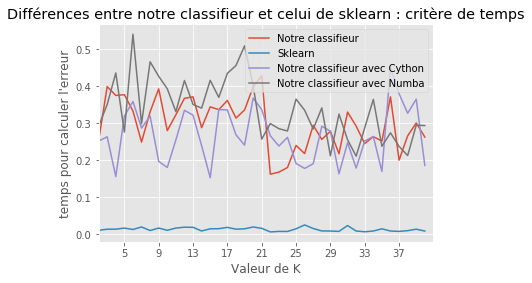

In [60]:
import KNN_Cython.KNN as KNN
from sklearn.neighbors import KNeighborsClassifier


from time import time

timeSklearn = []
timePerso = []
timePerso2 = []
timePersoNumba= []
nbTest=40
for k in range(1,nbTest+1):
    classifierKnn_sklearn=KNeighborsClassifier(n_neighbors=k).fit(x_train,class_train)
    startSklearn=time()
    errSKL=computeError(classifierKnn_sklearn.predict(x_test),class_test)
    timeSklearn.append(time()-startSklearn)
    startPerso=time()
    errKNN=computeError(testWithTrainOnTest(x_train,x_test,class_train,k),class_test)
    timePerso.append(time()-startPerso)
    startPerso2=time()
    errKNN=KNN.computeError(KNN.testWithTrainOnTest(x_train,x_test,class_train,k),class_test)
    timePerso2.append(time()-startPerso2)
    startPersoNumba=time()
    errKNN=computeErrorNumba(testWithTrainOnTestNumba(x_train,x_test,class_train,k),class_test)
    timePersoNumba.append(time()-startPersoNumba)
    
plt.figure()
plt.plot(np.linspace(1,nbTest,nbTest),timePerso,label='Notre classifieur')
plt.plot(np.linspace(1,nbTest,nbTest),timeSklearn,label='Sklearn')
plt.plot(np.linspace(1,nbTest,nbTest),timePerso2,label='Notre classifieur avec Cython')
plt.plot(np.linspace(1,nbTest,nbTest),timePersoNumba,label='Notre classifieur avec Numba')
plt.legend()
plt.title("Différences entre notre classifieur et celui de sklearn : critère de temps")
plt.xlabel("Valeur de K")
plt.ylabel("temps pour calculer l'erreur")
plt.xticks(np.arange(1, nbTest+1,4,dtype=int))
plt.xlim(2,nbTest+1)
plt.show()

In [6]:
@jit
def KNN_jit_opti(K, trainset, trainclass, testset):

    nb_train = trainset.shape[0]
    nb_test = testset.shape[0]
    nb_classes = max(trainclass)

    neighbours = np.zeros(K, dtype = np.intp)
    counts = np.zeros(nb_classes+1, dtype = np.intp)

    pred = []

    for i in range(nb_test):

        """ Distances """

        distances = []

        test_point_x = testset[i,0]
        test_point_y = testset[i,1]

        for j in range(nb_train):
            train_point_x = trainset[j,0]
            train_point_y = trainset[j,1]
            distances.append((train_point_x - test_point_x)*(train_point_x - test_point_x) + (train_point_y - test_point_y)*(train_point_y - test_point_y))

        """ Argsort """

        for i_argsort in range(nb_train):

            elt = distances[i_argsort]

            j_argsort = 0
            while(j_argsort < K and j_argsort < i_argsort and distances[neighbours[j_argsort]] < elt):
                j_argsort += 1

            if j_argsort < K:
                temp1 = neighbours[j_argsort]
                neighbours[j_argsort] = i_argsort

            j_argsort += 1
            while(j_argsort < K):
                temp2 = neighbours[j_argsort]
                neighbours[j_argsort] = temp1
                temp1 = temp2
                j_argsort += 1

        votes = [trainclass[neighbours[k]] for k in range(K)]

        """ Argmax Counts """

        for i_count in range(K):
            counts[votes[i_count]] += 1

        res = 0
        occs = 0

        for i_count in range(nb_classes+1):
            if counts[i_count] > occs:
                res = i_count
                occs = counts[res]
            counts[i_count] = 0

        """ Résultat """

        pred.append(res)

    return pred

pred = KNN_jit_opti(1, x_train, class_train, x_train)
np.array_equal(pred, class_train)

NameError: name 'x_train' is not defined

In [7]:
K=3
%%timeit -r 10
classifier_Knn_numpyNumba.KNN(K, x_train, class_train, x_test)

UsageError: Line magic function `%%timeit` not found.


In [ ]:
%%timeit -r 10
KNN_jit_opti(K, x_train, class_train, x_test)

In [ ]:
%%timeit -r 10
KNN(K, x_train, class_train, x_test)

In [ ]:
%%timeit -r 10
neigh = KNeighborsClassifier(n_neighbors=K)
neigh.fit(x_train, class_train)
pred_sklearn = neigh.predict(x_test)